In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd /content/drive/My Drive/Projet SatMap/Implementation

/content/drive/My Drive/Projet SatMap/Implementation


In [6]:
# Install required libs
!pip install tifffile
!pip install pypng


!pip install -U segmentation-models-pytorch albumentations --user 

Requirement already up-to-date: segmentation-models-pytorch in /root/.local/lib/python3.6/site-packages (0.1.0)
Requirement already up-to-date: albumentations in /root/.local/lib/python3.6/site-packages (0.4.5)


In [7]:
!pip install segmentation_models_pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import bin.data_opening as op
import bin.treatment as tr

import shapely.affinity
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import os
import png
import tifffile as tiff

In [0]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # Liste des images annotees
    IMAGES  = ['6010_1_2', '6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2', 
               '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3', '6100_2_2',
               '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0', '6120_2_0', '6120_2_2',
               '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1', '6170_0_4', '6170_2_4',
               '6170_4_1']
    # ID des classes respectives : batiments, routes, arbres, rivieres, lacs 
    CLASSES = ['1', '2', '3', '4', '5','6', '7', '8', '9', '10']
    
    def __init__(
            self,  
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        # convert str names to class values on masks
        self.classes = self.CLASSES[classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.path = "data"
        self.size = "grid_sizes.csv"
        self.polygons = "train_wkt_v4.csv"
        self.tiff_three_band = "three_band/{}.tif"
        self.tiff_sixteen_band = "sixteen_band/{}_M.tif"
    
    def __getitem__(self, i):
        
        # Ouverture des fichiers
        data_opening = op.DataOpening()
        treatment = tr.Treatment()

        image, img_size = data_opening.get_tiff(self.IMAGES[i])
        x_max, y_min = data_opening.get_size(self.IMAGES[i])
        train_polygons = data_opening.get_polygons(self.IMAGES[i], self.classes)

        # Traitment des fichiers
        #treatment = tr.Treatment()

        #png.fromarray(image).save("test.png")

        x_scaler, y_scaler = treatment.get_scalers(img_size, x_max, y_min)
        list_polygons = shapely.affinity.scale(train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
        mask = treatment.get_mask_polygons(img_size, list_polygons)

        # Save
        #image_PIL = Image.fromarray(treatment.get_img_rgb(image).astype('uint8'))
        #noun_image_file = "./data/data_train/images/image_" + str(i) + ".png"
        #image_PIL.save(noun_image_file)

        mask_PIL  = Image.fromarray((255 * mask).astype('uint8'))
        noun_mask_file = "./data/data_train/small_vehicles/image_" + str(i) + ".png"
        mask_PIL.save(noun_mask_file)

        # Modification des images
        image = treatment.get_img_rgb(image).astype('int32')
        #image = image.astype('int32')[:360, :480]
        #mask =  mask[:, :, np.newaxis].astype('float32')

        # apply augmentations
        if self.augmentation:
            #image = image
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #image = np.array(self.augmentation(Image.fromarray(image)))
            #mask = np.array(self.augmentation(Image.fromarray(mask)))
            #image = self.augmentation(image)
            #mask  = self.augmentation(mask)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.IMAGES)

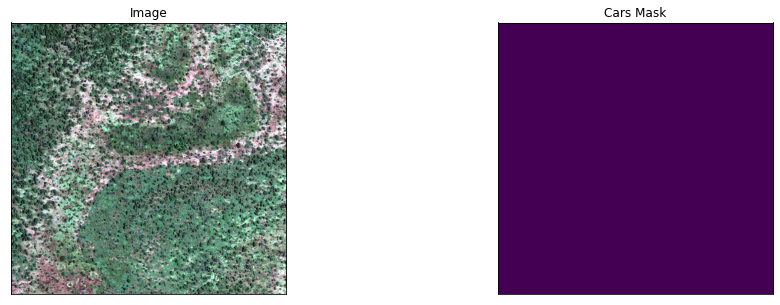

In [41]:
# Lets look at data we have

dataset = Dataset(classes=9) 

for i in range(25):
  image, mask = dataset[i] # get some sample

visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

#print(image)
#print(mask)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [0]:
import albumentations as albu
import torchvision.transforms as transforms

In [0]:
def get_training_augmentation():
      
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)
    """
    augment_transform = transforms.Compose([
        # Rotation aleatoire de quelques degres (10)
        transforms.RandomRotation(25),
        # Variation des contrastes et des couleurs 
        transforms.ColorJitter(),
        # Flip horizontal aleatoire
        transforms.RandomHorizontalFlip(),
        # Crop aleatoire
        transforms.RandomCrop(10),
    ])
    return augment_transform
    """
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [0]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset( 
    augmentation=get_training_augmentation(), 
    classes=2,
)

# same image with different random transforms
#for i in range(3):
#    image, mask = augmented_dataset[17]
#    visualize(image=image, mask=mask.squeeze(-1))

image, mask = augmented_dataset[15] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

## Create model and train

In [0]:
import torch
import numpy as np
import segmentation_models_pytorch as smp


In [0]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 2
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN( 
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [0]:
train_dataset = Dataset(  
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation(),
    classes=CLASSES,
)

valid_dataset = Dataset(  
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_validation_augmentation(),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [0]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [0]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [0]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

## Test best saved model

In [0]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [0]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [0]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

## Visualize predictions

In [0]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [0]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )